In [1]:
import sys
sys.path.append('../../../')

In [2]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

c:\Users\vibal\miniconda3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [4]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_rmse_perc'
metric_filter_2 = 'test_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [5]:
sets_lengths = (0.08, 0.02, 0.9)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [6]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [len(dataset_val.node_attributes)] * 2],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [7]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

100%|██████████| 24/24 [00:51<00:00,  2.15s/it]


#### Results

In [8]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 746/746 [00:21<00:00, 35.48it/s]


In [9]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.4380952380952381,
 'epoch': 56,
 'train_loss': 0.042766016,
 'val_loss': 0.05819223,
 'train_acc': 0.44999995827674866,
 'val_acc': 0.5666664838790894,
 'val_rmse_perc': 0.23556113,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.57_2023-03-30_12.05.23.457423',
 'train_rmse': 1.0327955589886444,
 'val_rmse': 0.9660917830792959,
 'test_rmse': 0.9899494936611666,
 'train_mae': 0.7166666666666667,
 'val_mae': 0.6,
 'test_mae': 0.6792592592592592,
 'train_mcc': 0.2901182641846422,
 'test_mcc': 0.2966998397917408,
 'test_acc': 0.46074074506759644,
 'train_rmse_perc': 0.24126673,
 'te

In [10]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [4, 4],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.3236694374850748,
 'epoch': 90,
 'train_loss': 0.044356395,
 'val_loss': 0.029511405,
 'train_acc': 0.3333333134651184,
 'val_acc': 0.49999985098838806,
 'val_rmse_perc': 0.17419961,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.50_2023-03-30_21.31.30.378540_90',
 'train_rmse': 0.917423929634859,
 'val_rmse': 0.7745966692414834,
 'test_rmse': 0.8989706047186127,
 'train_mae': 0.725,
 'val_mae': 0.5333333333333333,
 'test_mae': 0.6659259259259259,
 'train_mcc': 0.1577725288644732,
 'test_mcc': 0.23097123027641706,
 'test_acc': 0.40074074268341064,
 'train_rmse_perc': 0.21264741,
 't

In [11]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [4, 4],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.3768915491607762,
 'epoch': 100,
 'train_loss': 0.0443563,
 'val_loss': 0.029657265,
 'train_acc': 0.3333333134651184,
 'val_acc': 0.5333331823348999,
 'val_rmse_perc': 0.17431422,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.53_2023-03-30_12.05.37.820359',
 'train_rmse': 0.917423929634859,
 'val_rmse': 0.752772652709081,
 'test_rmse': 0.9055385138137416,
 'train_mae': 0.725,
 'val_mae': 0.5,
 'test_mae': 0.6703703703703704,
 'train_mcc': 0.1577725288644732,
 'test_mcc': 0.23144379032775492,
 'test_acc': 0.4000000059604645,
 'train_rmse_perc': 0.21216895,
 'test_rmse_perc': 0.2103

In [12]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 746/746 [00:00<00:00, 32437.81it/s]


In [13]:
cm = all[sort_idx[0]]['test_cm'][0]

In [14]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

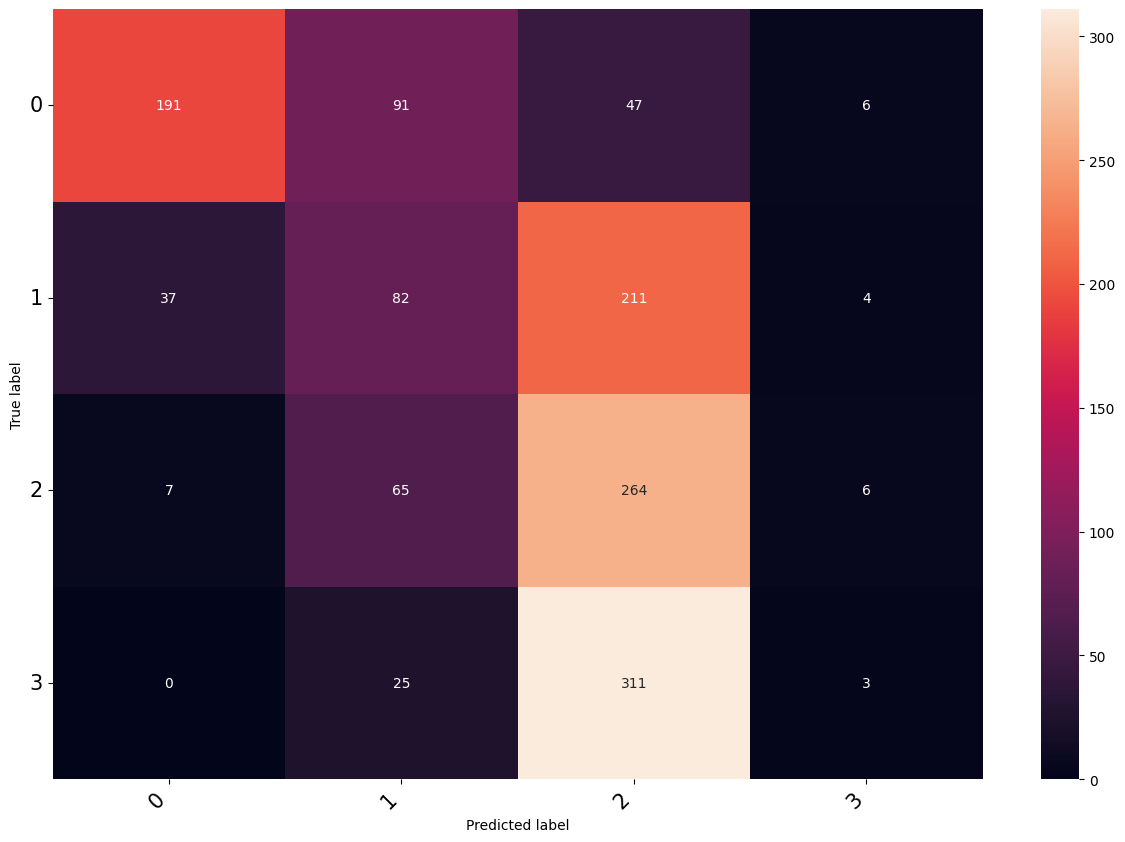

In [15]:
cm.visualize()

In [16]:
cm.class_accuracy

tensor([0.5701, 0.2455, 0.7719, 0.0088])

In [17]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.215714, 0.19492356, 0.14260346, 0.26898107]

In [18]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k]) for k in range(0, cm.size)]

[0.1716129, 0.17052576, 0.11066178, 0.25608575]

### GCN

In [19]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [20]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [05:37<00:00,  4.68s/it]


#### Results

In [21]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 1065/1065 [00:42<00:00, 24.94it/s]


In [22]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5382126540823101,
 'epoch': 30,
 'train_loss': 0.02870563,
 'val_loss': 0.050799504,
 'train_acc': 0.6749999523162842,
 'val_acc': 0.6666664481163025,
 'val_rmse_perc': 0.22297737,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.67_2023-03-30_21.32.41.558801_30',
 'train_rmse': 0.6708203932499369,
 'val_rmse': 0.8366600265340756,
 'test_rmse': 0.7308037178846821,
 'train_mae': 0.36666666666666664,
 'val_mae': 0.43333333333333335,
 'test_mae': 0.42,
 'train_mcc': 0.572095567365114,
 'test_mcc': 0.5154744447768107,
 'test_acc': 0.631851851940155,
 'train_rmse

In [23]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5346528522441568,
 'epoch': 20,
 'train_loss': 0.033978898,
 'val_loss': 0.019928468,
 'train_acc': 0.4583333134651184,
 'val_acc': 0.6666664481163025,
 'val_rmse_perc': 0.1555115,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.67_2023-03-30_21.32.41.558801_20',
 'train_rmse': 0.7691987172809551,
 'val_rmse': 0.5773502691896257,
 'test_rmse': 0.8133151181931155,
 'train_mae': 0.5583333333333333,
 'val_mae': 0.3333333333333333,
 'test_mae': 0.5503703703703704,
 'train_mcc': 0.3190277775882403,
 'test_mcc': 0.3689096417797928,
 'test_acc': 0.5007407665252686

In [24]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'both',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.4440028022691885,
 'epoch': 100,
 'train_loss': 0.02386108,
 'val_loss': 0.043213855,
 'train_acc': 0.6916666030883789,
 'val_acc': 0.5999997854232788,
 'val_rmse_perc': 0.20591235,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.60_2023-03-30_21.32.41.558801_100',
 'train_rmse': 0.5986094998689324,
 'val_rmse': 0.816496580927726,
 'test_rmse': 0.7231617820121324,
 'train_mae': 0.325,
 'val_mae': 0.4666666666666667,
 'test_mae': 0.43407407407407406,
 'train_mcc': 0.6002748825732254,
 'test_mcc': 0.491216383782709,
 'test_acc': 0.6066666841506958,
 'train_rm

In [25]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1065/1065 [00:00<00:00, 29295.98it/s]


### GraphSAGE

In [26]:
save_model = f'{save_path}_sage_dist'
log_dir = f'{log_path}_sage_dist'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [27]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 168/168 [1:02:50<00:00, 22.44s/it]


#### Results

In [28]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 2921/2921 [05:32<00:00,  8.78it/s]


In [29]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6687805545758807,
 'epoch': 80,
 'train_loss': 0.008294858,
 'val_loss': 0.01143741,
 'train_acc': 0.8499999642372131,
 'val_acc': 0.7666664123535156,
 'val_rmse_perc': 0.105981015,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.77_2023-03-30_22.33.15.019939_80',
 'train_rmse': 0.4183300132670378,
 'val_rmse': 0.48304589153964794,
 'test_rmse': 0.5537749241945383,
 'train_mae': 0.15833333333333333,
 'val_mae': 0.23333333333333334,
 'test_mae': 0.27555555555555555,
 'train_mcc': 0.8017476260888731,
 'test_mcc': 0.6546068728376354

In [30]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7244256247549917,
 'epoch': 50,
 'train_loss': 0.0049812044,
 'val_loss': 0.010558005,
 'train_acc': 0.9249999523162842,
 'val_acc': 0.7999997735023499,
 'val_rmse_perc': 0.09272639,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.80_2023-03-30_21.43.37.265797_50',
 'train_rmse': 0.27386127875258304,
 'val_rmse': 0.4472135954999579,
 'test_rmse': 0.5805489101161392,
 'train_mae': 0.075,
 'val_mae': 0.2,
 'test_mae': 0.30148148148148146,
 'train_mcc': 0.9005945812562289,
 'test_mcc': 0.6196244667589538,
 'test_acc': 0.714

In [31]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6687805545758807,
 'epoch': 100,
 'train_loss': 0.008266096,
 'val_loss': 0.011465361,
 'train_acc': 0.8499999642372131,
 'val_acc': 0.7666664123535156,
 'val_rmse_perc': 0.10598496,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.77_2023-03-30_22.33.15.019939_100',
 'train_rmse': 0.4183300132670378,
 'val_rmse': 0.48304589153964794,
 'test_rmse': 0.55444333110554,
 'train_mae': 0.15833333333333333,
 'val_mae': 0.23333333333333334,
 'test_mae': 0.2762962962962963,
 'train_mcc': 0.8017476260888731,
 'test_mcc': 0.6536481798626558,

In [32]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2921/2921 [00:00<00:00, 26235.28it/s]


#### cm

In [33]:
cm = all[sort_idx[0]]['test_cm'][0]

In [34]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

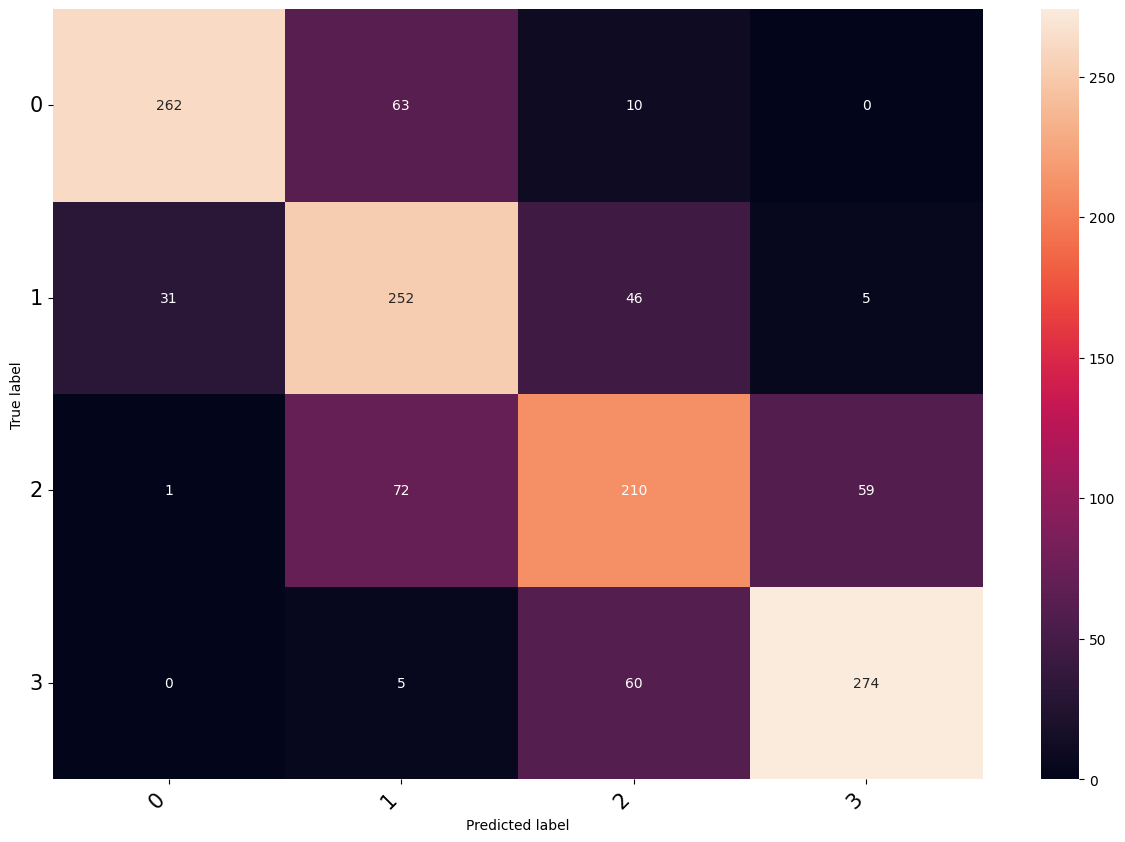

In [35]:
cm.visualize()

In [36]:
cm.class_accuracy

tensor([0.7821, 0.7545, 0.6140, 0.8083])

In [37]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.11187979, 0.12281127, 0.12362353, 0.12437823]

In [38]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k]) for k in range(0, cm.size)]

[0.07406783, 0.08507681, 0.096324876, 0.092449315]

#### GraphSAGE Base_n

In [39]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['mean', 'lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [40]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='base_n',
        )

100%|██████████| 336/336 [1:16:20<00:00, 13.63s/it]


##### Results

In [41]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='base_n',
)

100%|██████████| 5340/5340 [11:09<00:00,  7.98it/s]


In [42]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.44314722829403247,
 'epoch': 50,
 'train_loss': 0.008034148,
 'val_loss': 0.026777541,
 'train_acc': 0.5916666388511658,
 'val_acc': 0.5999997854232788,
 'val_rmse_perc': 0.120056085,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.60_2023-03-30_23.42.50.508865_50',
 'train_rmse': 0.6582805886043833,
 'val_rmse': 0.6324555320336759,
 'test_rmse': 0.7023769168568492,
 'train_mae': 0.4166666666666667,
 'val_mae': 0.4,
 'test_mae': 0.4414814814814815,
 'train_mcc': 0.520850398819945,
 'test_mcc': 0.48636269837407975,
 'test_ac

In [43]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.49858170925731227,
 'epoch': 40,
 'train_loss': 0.011523595,
 'val_loss': 0.026261542,
 'train_acc': 0.5999999642372131,
 'val_acc': 0.633333146572113,
 'val_rmse_perc': 0.11692519,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.63_2023-03-30_23.42.50.508865_40',
 'train_rmse': 0.6519202405202649,
 'val_rmse': 0.6055300708194983,
 'test_rmse': 0.7169895913289636,
 'train_mae': 0.4083333333333333,
 'val_mae': 0.36666666666666664,
 'test_mae': 0.4651851851851852,
 'train_mcc': 0.5338470932927505,
 'test_mcc': 0.4525632503237

In [44]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.44314722829403247,
 'epoch': 50,
 'train_loss': 0.008034148,
 'val_loss': 0.026777541,
 'train_acc': 0.5916666388511658,
 'val_acc': 0.5999997854232788,
 'val_rmse_perc': 0.120056085,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.60_2023-03-30_23.42.50.508865_50',
 'train_rmse': 0.6582805886043833,
 'val_rmse': 0.6324555320336759,
 'test_rmse': 0.7023769168568492,
 'train_mae': 0.4166666666666667,
 'val_mae': 0.4,
 'test_mae': 0.4414814814814815,
 'train_mcc': 0.520850398819945,
 'test_mcc': 0.48636269837407975,
 'test_ac

In [45]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 5340/5340 [00:00<00:00, 18164.99it/s]


##### cm

In [46]:
cm = all[sort_idx[0]]['test_cm'][0]

In [47]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

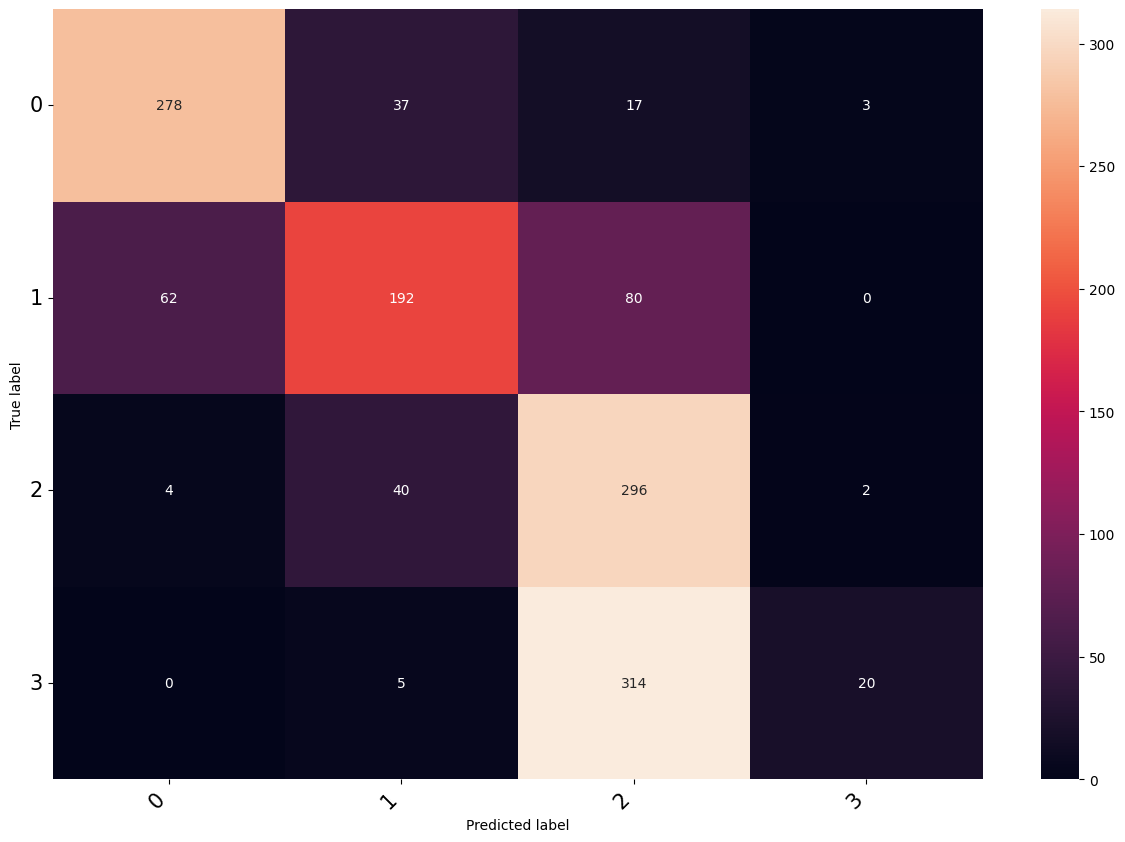

In [48]:
cm.visualize()

In [49]:
cm.class_accuracy

tensor([0.8299, 0.5749, 0.8655, 0.0590])

In [50]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.16863516, 0.12482597, 0.08718976, 0.19756179]

In [51]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k]) for k in range(0, cm.size)]

[0.09668238, 0.09605375, 0.067509815, 0.17663379]

#### GraphSAGE Scale

In [52]:
save_model = f'{save_path}_sage_scale'
log_dir = f'{log_path}_sage_scale'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['mean', 'lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [53]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='scale',
        )

100%|██████████| 336/336 [1:23:30<00:00, 14.91s/it]


##### Results

In [54]:
res_edges_sage_scale = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='scale',
)

100%|██████████| 5750/5750 [11:20<00:00,  8.45it/s]


In [55]:
res_edges = res_edges_sage_scale
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5421151989096864,
 'epoch': 80,
 'train_loss': 0.010116731,
 'val_loss': 0.027939655,
 'train_acc': 0.8583332896232605,
 'val_acc': 0.6666664481163025,
 'val_rmse_perc': 0.15404807,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.67_2023-03-31_01.15.30.863212_80',
 'train_rmse': 0.408248290463863,
 'val_rmse': 0.6582805886043833,
 'test_rmse': 0.6283429118043864,
 'train_mae': 0.15,
 'val_mae': 0.36666666666666664,
 'test_mae': 0.32814814814814813,
 'train_mcc': 0.8154920111019092,
 'test_mcc': 0.6075377675844287,
 'test_ac

In [56]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.8194965287937439,
 'epoch': 79,
 'train_loss': 0.042891107,
 'val_loss': 0.018039433,
 'train_acc': 0.8416666388511658,
 'val_acc': 0.8666663765907288,
 'val_rmse_perc': 0.12281855,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.87_2023-03-31_00.22.47.098928',
 'train_rmse': 0.4281744192888376,
 'val_rmse': 0.48304589153964794,
 'test_rmse': 0.7338382100425941,
 'train_mae': 0.16666666666666666,
 'val_mae': 0.16666666666666666,
 'test_mae': 0.40370370370370373,
 'train_mcc': 0.7926739797813105,
 'test_mcc': 0.541324

In [57]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5746751208615254,
 'epoch': 30,
 'train_loss': 0.022761375,
 'val_loss': 0.034857526,
 'train_acc': 0.8249999284744263,
 'val_acc': 0.6999997496604919,
 'val_rmse_perc': 0.14437981,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.70_2023-03-31_01.02.10.867737_30',
 'train_rmse': 0.4743416490252569,
 'val_rmse': 0.5477225575051661,
 'test_rmse': 0.6200358412579424,
 'train_mae': 0.19166666666666668,
 'val_mae': 0.3,
 'test_mae': 0.3414814814814815,
 'train_mcc': 0.7688162766753286,
 'test_mcc': 0.5764939731939038,
 'test_acc

In [58]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 5750/5750 [00:00<00:00, 17014.59it/s]


##### cm

In [59]:
cm = all[sort_idx[0]]['test_cm'][0]

In [60]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

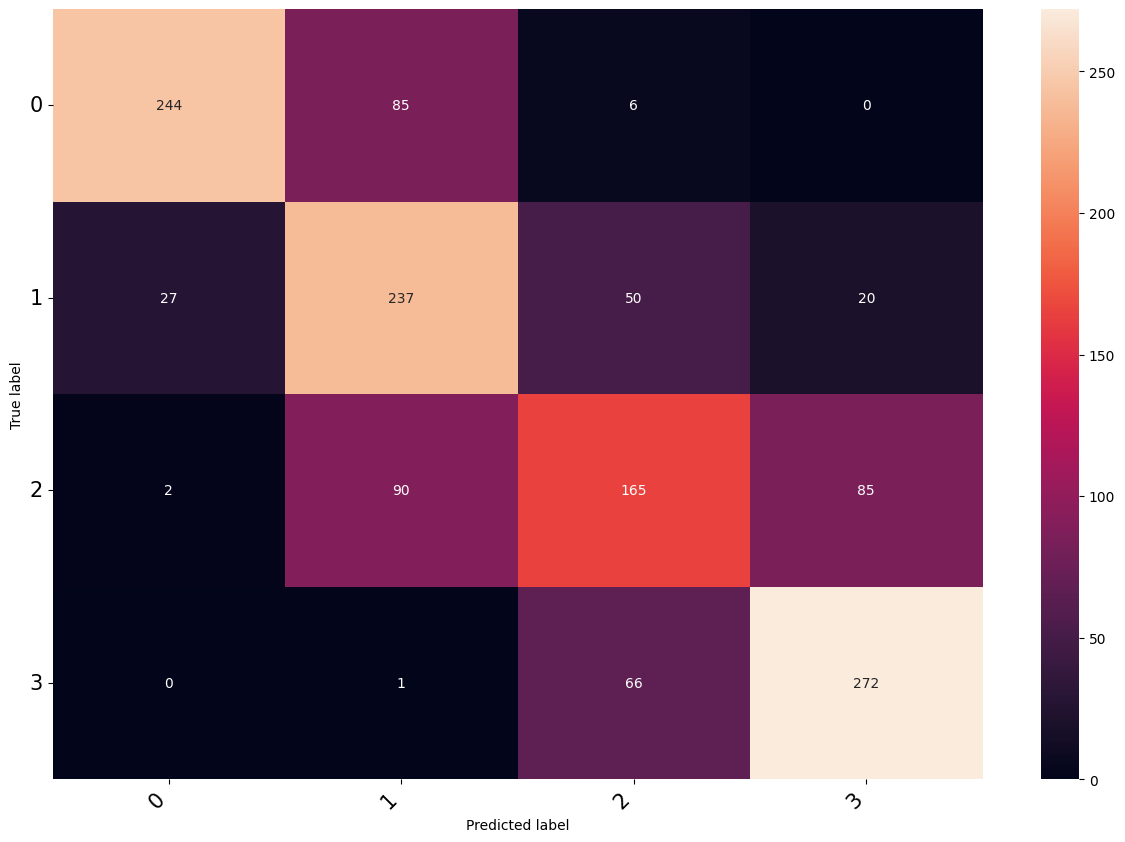

In [61]:
cm.visualize()

In [62]:
cm.class_accuracy

tensor([0.7284, 0.7096, 0.4825, 0.8024])

In [63]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.11941393, 0.1547642, 0.14401934, 0.1229961]

In [64]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.perc[cm.labels==k]) for k in range(0, cm.size)]

[0.08783304, 0.113169484, 0.11680231, 0.09934622]

### GAT

In [65]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[True, False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [66]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 576/576 [47:53<00:00,  4.99s/it] 


#### Results

In [67]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 7432/7432 [05:32<00:00, 22.35it/s]


In [68]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [20],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': None,
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.1974977550187474,
 'epoch': 12,
 'train_loss': 0.20639938,
 'val_loss': 0.047751237,
 'train_acc': 0.34166663885116577,
 'val_acc': 0.3999998867511749,
 'val_rmse_perc': 0.22822577,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.40_2023-03-31_02.12.59.865701',
 'train_rmse': 1.1510864433221337,
 'val_rmse': 0.8944271909999159,
 'test_rmse': 1.0201670161011582,
 'train_mae': 0.8583333333333333,
 'val_mae': 0.6666666666666666,
 'test_mae': 0.6925925925925925,
 'train_mcc': 0.13734761090363673,
 'test

In [69]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.134078218086324,
 'epoch': 20,
 'train_loss': 0.050939523,
 'val_loss': 0.039853696,
 'train_acc': 0.4583333134651184,
 'val_acc': 0.33333322405815125,
 'val_rmse_perc': 0.2049784,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.33_2023-03-31_02.05.58.877707_20',
 'train_rmse': 0.8416254115301732,
 'val_rmse': 0.816496580927726,
 'test_rmse': 0.9714441330841953,
 'train_mae': 0.5916666666666667,
 'val_mae': 0.6666666666666666,
 'test_mae': 0.682962962962963,
 'train_mcc': 0.2829136834267641,
 'test_mc

In [70]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.184143824752997,
 'epoch': 40,
 'train_loss': 0.051327843,
 'val_loss': 0.041820277,
 'train_acc': 0.4583333134651184,
 'val_acc': 0.3666665554046631,
 'val_rmse_perc': 0.20871143,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.37_2023-03-31_02.05.58.877707_40',
 'train_rmse': 0.8010409893798611,
 'val_rmse': 0.8563488385776752,
 'test_rmse': 0.9193395374861157,
 'train_mae': 0.575,
 'val_mae': 0.6666666666666666,
 'test_mae': 0.6570370370370371,
 'train_mcc': 0.2921626240901565,
 'test_mcc': 0.25914

In [71]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 7432/7432 [00:00<00:00, 25103.58it/s]
